
Required to work:

Plotly (pip install plotly)

pandas_datareader (pip install pandas_datareader)

datetime

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import itertools
import collections, numpy


import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from math import sqrt

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
from plotly import tools

from sklearn import preprocessing, svm, cross_validation
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix


pd.options.mode.chained_assignment = None  # default='warn'


pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader.data import DataReader


/Users/peterparikka/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



 Read in data

In [2]:
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4873195/
end = dt.datetime.now()
start = end - dt.timedelta(days=5*365)

df_tesla = DataReader('TSLA', 'iex', start, end)
df_tesla.index = pd.to_datetime(df_tesla.index, format='%Y-%m-%d')
# Drop row if null
df_tesla.dropna(inplace=True)


5y


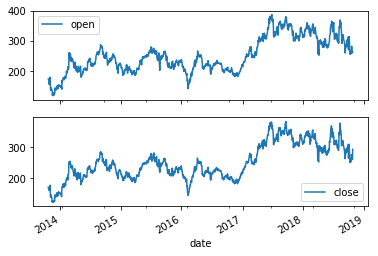

In [3]:

fig = plt.figure()
ax1 = plt.subplot2grid((2,1), (0,0))
ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)

#set ticks every week
ax1.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

df_tesla[['open']].plot(ax=ax1)
df_tesla[['close']].plot(ax=ax2)

plt.legend(loc=4)

plt.show()

Log feature type 1

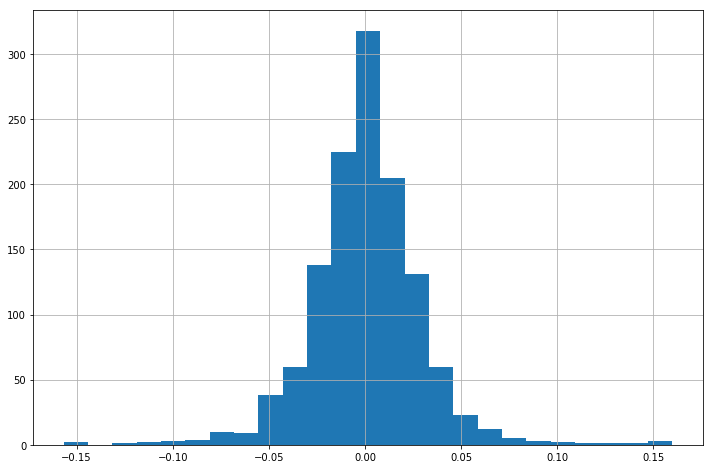

In [4]:
df_tesla['Log_Ret'] = np.log(df_tesla['close'] / df_tesla['close'].shift(1))
df_tesla['Log_Ret'].hist(bins=25, figsize=(12,8))


In [5]:

trace = go.Candlestick(x=df_tesla.index,
                       open=df_tesla.open,
                       high=df_tesla.high,
                       low=df_tesla.low,
                       close=df_tesla.close)

layout = go.Layout(
        xaxis = dict(
        rangeslider = dict(
            visible = False
        )
    )
)

data = [trace]

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename='tesla_candelStick')

In [6]:
df_tesla.dropna(inplace=True)


Rolling avrage feature type 2

In [7]:
df_tesla['R_AVG'] = df_tesla['close'].rolling(window=5).mean()


BIAS6 feature type 2

In [8]:
df_tesla['R_AVG6'] = df_tesla['close'].rolling(window=6).mean()

df_tesla['BIAS6'] = ((df_tesla['close'] - df_tesla['R_AVG6']) / df_tesla['R_AVG6']) * 100.00


In [9]:
df_tesla.drop(['R_AVG6'], 1, inplace=True)
df_tesla.dropna(inplace=True)


ROC feature type 1

In [10]:
def ROC(df, n):
    M = df['close'].diff(n -1)
    N = df['close'].shift(n -1)
    roc = pd.Series(((M / N) * 100), name = 'roc_' + str(n))   
    return roc

roc_series = ROC(df_tesla, 14)

df_tesla['ROC_14'] = roc_series
df_tesla.dropna(inplace=True)


In [11]:
INCREASING_COLOR = '#00FFFF'
DECREASING_COLOR = '#000000'

In [12]:
data = [ dict(
    type = 'candlestick',
    open = df_tesla.open,
    high = df_tesla.high,
    low = df_tesla.low,
    close = df_tesla.close,
    x = df_tesla.index,
    yaxis = 'y2',
    name = 'GS',
    increasing = dict( line = dict( color = INCREASING_COLOR ) ),
    decreasing = dict( line = dict( color = DECREASING_COLOR ) ),
) ]

layout=dict()

fig = dict( data=data, layout=layout )

In [13]:
fig['layout'] = dict()
fig['layout']['plot_bgcolor'] = 'rgb(250, 250, 250)'
fig['layout']['xaxis'] = dict( rangeselector = dict( visible = True ) )
fig['layout']['yaxis'] = dict( domain = [0, 0.2], showticklabels = False )
fig['layout']['yaxis2'] = dict( domain = [0.2, 0.8] )
fig['layout']['legend'] = dict( orientation = 'h', y=0.9, x=0.3, yanchor='bottom' )
fig['layout']['margin'] = dict( t=40, b=40, r=40, l=40 )

In [14]:
rangeselector=dict(
    visibe = True,
    x = 0, y = 0.9,
    bgcolor = 'rgba(150, 200, 250, 0.4)',
    font = dict( size = 13 ),
    buttons=list([
        dict(count=1,
             label='reset',
             step='all'),
        dict(count=1,
             label='1yr',
             step='year',
             stepmode='backward'),
        dict(count=3,
            label='3 mo',
            step='month',
            stepmode='backward'),
        dict(count=1,
            label='1 mo',
            step='month',
            stepmode='backward'),
        dict(step='all')
    ]))
    
fig['layout']['xaxis']['rangeselector'] = rangeselector

In [15]:
fig['data'].append( dict( x=df_tesla.index, y=df_tesla.BIAS6, type='scatter', mode='lines', 
                         line = dict( width = 1 ),
                         marker = dict( color = 'darkgreen' ),
                         yaxis = 'y2', name='BIAS6' ) )

In [16]:
colors = []

for i in range(len(df_tesla.close)):
    if i != 0:
        if df_tesla.close[i] > df_tesla.close[i-1]:
            colors.append(INCREASING_COLOR)
        else:
            colors.append(DECREASING_COLOR)
    else:
        colors.append(DECREASING_COLOR)

In [17]:
fig['data'].append( dict( x=df_tesla.index, y=df_tesla.volume,                         
                         marker=dict( color=colors ),
                         type='bar', yaxis='y', name='Volume' ) )

In [18]:
fig['data'].append( dict( x=df_tesla.index, y=df_tesla.ROC_14, type='scatter', yaxis='y2', 
                         line = dict( width = 1 ),
                         marker=dict(color='#ccc'), 
                         legendgroup='roc_14', name='roc_14') )


fig['data'].append( dict( x=df_tesla.index, y=df_tesla.R_AVG, type='lines', yaxis='y2',
                           line = dict( width = 1 ),
                            marker=dict(color='#E377C2'),
                             name='R_AVG', showlegend=True ) )


fig['data'].append( dict( x=df_tesla.index, y=df_tesla.Log_Ret, type='lines', yaxis='y2',
                           line = dict( width = 1 ),
                            marker=dict(color='#E377C2'),
                             name='Log_Ret', showlegend=True ) )



In [19]:
iplot( fig, filename = 'candlestick_roc_plotting', validate = False )


Regession start

Create data to be passed to Neural network

In [20]:
df = df_tesla.copy()

forecast_col = 'close'
# how many days to forecast
forecast_out = int(10) # I desided to forecast 10 days
print('length =',len(df), "and forecast_out =", forecast_out)

length = 1239 and forecast_out = 10


Shift label with as many says as u wanna forecast

In [21]:
df['label'] = df[forecast_col].shift(-forecast_out)

In [22]:
# Define features Matrix X by excluding the label column
X = np.array(df.drop(['label'], 1))

# preposessing to scale features
X = preprocessing.scale(X)
print(X[1,:])

[-2.34728569 -2.3762579  -2.37064164 -2.35601712  1.30473863 -0.23634639
 -2.33792296 -0.8088964  -3.27966403]


X_forecast_out will exclude the last 10 days that has null data

In [23]:
# X contains last 'n= forecast_out' rows for which we don't have label data
# Put those rows in different Matrix X_forecast_out by X_forecast_out = X[end-forecast_out:end]

X_forecast_out = X[-forecast_out:]
X = X[:-forecast_out]
print ("Length of X_forecast_out:", len(X_forecast_out), "& Length of X :", len(X))


Length of X_forecast_out: 10 & Length of X : 1229


In [24]:
# Y get only the labeled data
# X and y lenght should be identical
y = np.array(df['label'])
y = y[:-forecast_out]
print('Length of y: ',len(y))


Length of y:  1229


In [25]:
# Cross validation (split into test and train data)
# test_size = 0.2 ==> 20% data is test data
#X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.2)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

splitIndex = round(len(X)*0.8)

X_train, X_test, y_train, y_test = X[:splitIndex], X[splitIndex:], y[:splitIndex], y[splitIndex:]

#tscv = TimeSeriesSplit(n_splits=5)

#for train_index, test_index in tscv.split(X):
#    X_train, X_test = X[train_index], X[test_index]
#    y_train, y_test = y[train_index], y[test_index]
#print('length of X_train and x_test: ', len(X_train), len(X_test))

In [26]:
# Train
clf = LinearRegression()
clf.fit(X_train,y_train)
# Test
accuracy = clf.score(X_test, y_test)
print("Accuracy of Linear Regression: ", accuracy)

# The coefficients
print('Coefficients: \n', clf.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((clf.predict(X_test) - y_test) ** 2))
# Explained variance score: 1 is perfect prediction


Accuracy of Linear Regression:  -0.18145621094040387
Coefficients: 
 [-28.19446558  -2.26858587  51.69259556  15.87251643   3.34924262
   0.38174947  14.11190152   0.91564339   0.56202872]
Mean squared error: 796.02


In [27]:
forecast_prediction = clf.predict(X_forecast_out)

In [28]:
df.dropna(inplace=True)
# insert last day of close data to forecast to match the lines
forecast_prediction = np.insert(forecast_prediction, 0, df.iloc[-1].close)


In [29]:
# Plotting data
df['forecast'] = np.nan
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_prediction:
    next_date = dt.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]

In [30]:
p1 = go.Scatter(x=df.index,
                y=df.close, 
                mode='lines',
                name='open',
                marker=dict(color='green')
               )
p2 = go.Scatter(x=df.index, 
                y=df.forecast,
                mode='lines',
                name='forecast',
                line=dict(color='blue', width=3)
                )

layout = go.Layout(title='Forecast plot',width=1000,height=1000,
xaxis=dict(title='Date',ticks='', showticklabels=True,
                              zeroline=False),
                   yaxis=dict(title='Price',ticks='', showticklabels=True,
                              zeroline=False),
                   showlegend=True)

fig = go.Figure(data=[p1, p2], layout=layout)

iplot(fig)

In [31]:
trace1 = go.Scatter(dict(line=dict(color='darkblue'),
                      x=df.index,
                      y=clf.predict(X_test),
                      name='regression( predicted )'))

trace2 = go.Scatter(dict(line=dict(color='green'),
                      x=df.index,
                      y=y_test.flatten(),
                      name='regression ( Y_test/expected )'))



layout = go.Layout(width=1000,height=1000,xaxis=dict(ticks='', showticklabels=True,
                              zeroline=False),
                   yaxis=dict(ticks='', showticklabels=True,
                              zeroline=False),
                   showlegend=True)

fig = go.Figure(data=[trace1, trace2], layout=layout)

iplot(fig)

In [32]:
EnModel = ElasticNetCV()
EnModel.fit(X_train, y_train)
print('ElasticNetCv": %.4f' % EnModel.score(X_test, y_test))


ElasticNetCv": -0.1703


Testing with ensemble.GradientBoostingRegressor() and ferature testing

In [33]:
model = ensemble.GradientBoostingRegressor()
model.fit(X_train, y_train)
print('Gradient Boosting R squared": %.4f' % model.score(X_test, y_test))


Gradient Boosting R squared": -0.9016


In [34]:
y_pred = model.predict(X_test)
print("Mean squared error: %.2f"
      % np.mean((model.predict(X_test) - y_test) ** 2))


Mean squared error: 1281.25


In [35]:
feature_labels = np.array(['open','high','low','close','volume','Log_Ret','R_AVG','BIAS6','ROC_14'])
importance = model.feature_importances_
feature_indexes_by_importance = importance.argsort()
for index in feature_indexes_by_importance:
    print('{}-{:.2f}%'.format(feature_labels[index], (importance[index] *100.0)))

open-2.91%
BIAS6-8.22%
Log_Ret-8.74%
close-8.83%
high-10.89%
volume-11.77%
ROC_14-13.49%
R_AVG-16.43%
low-18.73%


5 determine buy or sell indicators

In [36]:
df_plot = pd.DataFrame(index=df.index)
df_plot['close'] = df['close']


## Project –Decision support for trading

The grade is based on the accomplished tasks below and the presentation. Read https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0194889•Grade 

1:You need to calculate errors for regression forecast of three models, using sMAPEand MASE. Plot in a table and compare models.   DONE

•Grade 2:Create a decision, state clearly in the notebook what the strategy is about. The decision taken should be the same as what you describe. Compare decision to optimal decision, present some statistical evidence, e.ghit rate.•Grade 

3:Visualize the decision on the price graph, different color each decision. Use an interactive graph. Create a confusion matrix for the decision outcomes.

•Grade 4:Calculate the quality of the decision by determining the return on investments (P/L account). Visualize in a graph how the P/L account changes over time. For this grade you may use a library for back-testing if you like.

•Grade +1:Choose your own improved model or output. E.g. an ensemble, several outputs and so on. Use this in the above and compare the difference to a baseline.


## Grade 1

Mean square Error (MAPE)

In [37]:
mseLR = np.mean((clf.predict(X_test) - y_test) ** 2)
mseGB = np.mean((model.predict(X_test) - y_test) ** 2)

Mean Absolute Percentage Error (MAPE)

In [38]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


Root Mean Squared Error


Symmetric mean absolute percentage error(sMAPE)


In [39]:
def sMAPE(y_true,  y_pred):
    prec = 100.00/len(y_true)
    FA = np.abs(y_pred - y_true)
    F = np.abs(y_pred)
    A = np.abs(y_true)
    
    r = sum(FA / ((A + F) / 2))
    
    result = np.mean(r * prec)
    return result

Mean absolute scaled error(MASE) non-seasonal time series


In [40]:
def MASE(y_true, y_predict, x_train):
    e = np.abs(y_true - y_predict)
    denominator = sum(np.abs( np.diff( x_train[1:]) ))
    
    div = (len(y_true)-1)
    
    return np.mean(e) / (denominator / div )


In [41]:
linearRegression = []
gradientBoostingRegressor = []
elasticNetCv = []

In [42]:
## MSE, MAPE, sMAPE, MASE, RMSE
linearRegression.extend((
    mean_squared_error(y_test, clf.predict(X_test)), 
    mean_absolute_percentage_error(y_test, clf.predict(X_test)),
    sMAPE(y_test, clf.predict(X_test)),
    MASE(y_test, clf.predict(X_test), y_train),
    sqrt(mseLR)
))

gradientBoostingRegressor.extend((
    mean_squared_error(y_test, model.predict(X_test)), 
    mean_absolute_percentage_error(y_test, model.predict(X_test)),
    sMAPE(y_test, model.predict(X_test)),
    MASE(y_test, model.predict(X_test), y_train),
    sqrt(mseGB)
))

elasticNetCv.extend((
    mean_squared_error(y_test, EnModel.predict(X_test)), 
    mean_absolute_percentage_error(y_test, EnModel.predict(X_test)),
    sMAPE(y_test, EnModel.predict(X_test)),
    MASE(y_test, EnModel.predict(X_test), y_train),
    sqrt(mseGB)
))

In [43]:
df_error = pd.DataFrame() 
df_error = pd.DataFrame(
   [linearRegression,
   gradientBoostingRegressor,
   elasticNetCv],
    index=['linearR','GBR', 'ENC'],
    columns=['MSE', 'MAPE', 'sMAPE', 'MASE', 'RMSE']
)

In [44]:
df_error

MSE      MAPE     sMAPE      MASE       RMSE
linearR   796.015469  7.152967  7.157309  1.275482  28.213746
GBR      1281.246790  9.879049  9.605397  1.732258  35.794508
ENC       788.496632  7.136399  7.155609  1.274792  35.794508

## 2   Create a decision, state clearly in the notebook what the strategy is about. The decision taken should be the same as what you describe. Compare decision to optimal decision, present some statistical evidence, e.ghit rate.


## DESCISION STRATEGY
My decision i based on calculating bollinger bands. Approximately 90% of price action should occur between the two bands and my decision for by or cell is based on both close price and predicted price going lower or higher than the bands.

In [45]:
symbol='TSLA'

df1 = df_plot.rename(columns={'close': symbol})

df1.dropna(inplace=True)
sma = df1.rolling(window=15).mean()

# calculate the standar deviation
rstd = df1.rolling(window=15).std()

upper_band = sma + 2 * rstd
upper_band = upper_band.rename(columns={symbol: 'upper'})
lower_band = sma - 2 * rstd
lower_band = lower_band.rename(columns={symbol: 'lower'})


df2 = df1.join(upper_band).join(lower_band)

df2.dropna(inplace=True)

In [46]:
predx_test = EnModel.predict(X_test)
df_tsla246 = df1[-len(predx_test):]
df_bollinger246 = df2[-len(predx_test):]

In [47]:
def createBuySellIndicators(df_bollinger246, predx_test): 
    result = []
    resultWithData = []
    k = 0
    for day, data in df_bollinger246.iterrows():
        
        if data['TSLA'] >= data['upper'] and predx_test[k] >= data['upper']:
            #Sell
            result.append(-1)
            k = k+1

        elif data['TSLA'] < data['lower'] and predx_test[k] < data['lower']:
            #Buy
            k = k+1
            result.append(1)
        else:
            result.append(0)
            k = k+1
            
    df_bollinger246['buyOrSell'] = result
    df_bollinger246['predicted'] = predx_test      
    return result

indicatorarray = createBuySellIndicators(df_bollinger246, predx_test)

In [48]:
def isNot(value , compareTo):
    return value is not compareTo

Here i further improve my decition on buy or sell by taking two buy/sell markers and checking which of the values in between is smaller or bigger and asigning a new buy/sell marker on the lowest point 

In [49]:
def calculateBuyAndSell(dataFrame, serie):
    
    dataFrame['buySellNew'] = 0
    lastValue = 0
    lastTimeStamp = 0
    newTimestamp = 0

    
    for i, v in enumerate(dataFrame['buyOrSell']):
        
        if isNot(v, 0):
            
            if v == 1:
                #BUY
                if isNot(lastValue, 0):
                    newTimestamp = dataFrame[serie][lastValue:i +1].idxmin()

                    if isNot(lastTimeStamp, 0):
                        if dataFrame.loc[lastTimeStamp, serie] > dataFrame.loc[newTimestamp, serie]:
                            
                            dataFrame.loc[newTimestamp, 'buySellNew'] = 1
                lastTimeStamp = newTimestamp
                lastValue = i
                    
            if v == -1:
                #SELL
                if isNot(lastValue, 0):
                    newTimestamp = dataFrame[serie][lastValue:i +1].idxmax()
                    if isNot(lastTimeStamp, 0):
 
                        if dataFrame.loc[lastTimeStamp, serie] < dataFrame.loc[newTimestamp, serie]:
                            dataFrame.loc[newTimestamp, 'buySellNew'] = -1
                    lastTimeStamp = newTimestamp
                lastValue = i

    return dataFrame

In [61]:
dfNewTSLA = calculateBuyAndSell(df_bollinger246, 'TSLA')
dfNewPred = calculateBuyAndSell(df_bollinger246, 'predicted')


## HIT RATIO

## $$ Pi = 1, (y_{t+1}−y_t)(yˆ_{t+1}−yˆ_t)>0,0,otherwise.$$

In [62]:
def calculatePi(act, predict):
    
    actu = np.diff(act)
    pre = np.diff(predict)
    
    #print(np.mean(actu * pre))
    if np.mean(actu * pre) > 0:
        return 1
    else:
        return 0
    

## $$ Hit ratio =  \frac{1}{n} \sum^n_{i=1}P_i (i = 1,2,...,n), $$

In [63]:
def hitRatio(y_test, predict):
    lenght = len(y_test)
    cP = []

    for i, o in enumerate(y_test):
        cP.append(calculatePi(y_test[i:], predict[i:]))
    hit = (1 / lenght) * sum(cP)
    
    return hit, cP


In [64]:
hitR, hitArr = hitRatio(y_test, predx_test)

/Users/peterparikka/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning:

Mean of empty slice.

/Users/peterparikka/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning:

invalid value encountered in double_scalars



In [65]:
actual = np.array(dfNewTSLA['buySellNew'])
pred = np.array(dfNewPred['buySellNew'])

dfBuyOrSell = dfNewTSLA.copy()
confusion_matrix(actual, pred)

array([[  4,   0,   0],
       [  0, 232,   0],
       [  0,   0,  10]])

In [66]:
dfBuyOrSell['buyOrSellPred'] = dfNewPred['buySellNew']


In [67]:
array = [1, -1]
confusionM = dfBuyOrSell.loc[dfBuyOrSell['buyOrSellPred'].isin(array)].reset_index()
confusionM

date    TSLA       upper       lower  buyOrSell   predicted  \
0  2017-11-02  299.26  370.301276  301.388057          1  299.253836   
1  2017-11-09  302.99  348.689786  289.522214          0  297.121854   
2  2018-02-09  310.42  366.728982  314.756351          1  309.358606   
3  2018-03-27  279.18  352.717417  285.167917          1  284.790792   
4  2018-03-28  257.78  359.282522  268.666811          1  263.249545   
5  2018-06-06  319.50  308.885673  264.782327         -1  318.248118   
6  2018-06-12  342.77  341.690958  255.482375         -1  347.158325   
7  2018-07-03  310.86  374.646676  316.783991          1  313.226923   
8  2018-07-24  297.43  329.701905  299.034095          1  297.679551   
9  2018-07-30  290.17  332.605451  290.171882          1  287.925171   
10 2018-08-02  349.54  340.523884  280.970783         -1  347.731638   
11 2018-08-07  379.57  369.547125  267.690208         -1  373.307873   
12 2018-09-05  280.74  343.897902  280.792764          1  279.145872   
13 2018-09-07  263.24  339.649484  267.714516          1  265.514531   

    buySellNew  buyOrSellPred  
0            1              1  
1            1              1  
2            1              1  
3            1              1  
4            1              1  
5           -1             -1  
6           -1             -1  
7            1              1  
8            1              1  
9            1              1  
10          -1             -1  
11          -1             -1  
12           1              1  
13           1              1

In [122]:
def confusionMatrix(df, serie):
    
    tempList = []

    
    direction = df['buySellNew'][0]
    rangeCounter = 1
    
    for i, value in enumerate(df['buySellNew']):
        
        if i == 0:

            tempList.append(value)
            continue

        if direction != value or i == (len(df['buySellNew']) -1):
            for k in range(rangeCounter):

                if df['TSLA'][i] > df['TSLA'][i - (k + 1)]:
                    tempList.append(1)

                else:
                    tempList.append(-1)
                    
            direction = value
            rangeCounter = 1
        else:
            rangeCounter = rangeCounter + 1

    return tempList
        

In [123]:
controlList = confusionMatrix(confusionM, 'buySellNew')

In [92]:
confusionM['new'] = controlList

In [93]:
confusionM

date    TSLA       upper       lower  buyOrSell   predicted  \
0  2017-11-02  299.26  370.301276  301.388057          1  299.253836   
1  2017-11-09  302.99  348.689786  289.522214          0  297.121854   
2  2018-02-09  310.42  366.728982  314.756351          1  309.358606   
3  2018-03-27  279.18  352.717417  285.167917          1  284.790792   
4  2018-03-28  257.78  359.282522  268.666811          1  263.249545   
5  2018-06-06  319.50  308.885673  264.782327         -1  318.248118   
6  2018-06-12  342.77  341.690958  255.482375         -1  347.158325   
7  2018-07-03  310.86  374.646676  316.783991          1  313.226923   
8  2018-07-24  297.43  329.701905  299.034095          1  297.679551   
9  2018-07-30  290.17  332.605451  290.171882          1  287.925171   
10 2018-08-02  349.54  340.523884  280.970783         -1  347.731638   
11 2018-08-07  379.57  369.547125  267.690208         -1  373.307873   
12 2018-09-05  280.74  343.897902  280.792764          1  279.145872   
13 2018-09-07  263.24  339.649484  267.714516          1  265.514531   

    buySellNew  buyOrSellPred  new  
0            1              1    1  
1            1              1    1  
2            1              1    1  
3            1              1    1  
4            1              1    1  
5           -1             -1    1  
6           -1             -1   -1  
7            1              1   -1  
8            1              1    1  
9            1              1    1  
10          -1             -1    1  
11          -1             -1   -1  
12           1              1   -1  
13           1              1   -1

In [94]:
hite, hitAr = hitRatio(confusionM['buyOrSellPred'].tolist(), controlList)
hite

/Users/peterparikka/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning:

Mean of empty slice.

/Users/peterparikka/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning:

invalid value encountered in double_scalars



0.0

## 4:Calculate the quality of the decision by determining the return on investments (P/L account). Visualize in a graph how the P/L account changes over time. 

In [151]:
def ROI(df): 
    
    balance = 0
    tempList = []
    
    for i, value in enumerate(df['buySellNew']):
             
        if value == 1:
            balance = balance + df['TSLA'][i]
            tempList.append("{:.2f}".format(balance))
            
        elif value == -1:
            balance = balance - df['TSLA'][i]
            tempList.append("{:.2f}".format(balance))
        else:
            tempList.append(0) 
        
    return  tempList , balance
        

In [152]:
bList, balance = ROI(dfNewTSLA)
print('Return on investment: ', "{:.2f}".format(balance))

Return on investment:  1500.69


In [145]:
dfNewTSLA['balance'] = bList
dfNewTSLA['closeMarkersValues'] = dfNewTSLA['TSLA'][dfNewTSLA['balance'] != 0]

# Replace 0 with '' to display correctly in plot
dfNewTSLA.replace(0, dfNewTSLA['balance'].replace([0], [''], inplace=True))
# Replace nan values with ''
dfNewTSLA.replace(np.nan, dfNewTSLA['closeMarkersValues'].replace([np.nan], [''], inplace=True))
dfNewTSLA.head(20)

TSLA       upper       lower  buyOrSell   predicted  buySellNew  \
date                                                                            
2017-10-18  359.65  364.656612  337.739388          0  349.932664           0   
2017-10-19  351.81  363.842854  340.181146          0  343.225033           0   
2017-10-20  345.10  363.200848  341.356485          0  339.329415           0   
2017-10-23  337.02  364.323806  339.632194          1  333.826718           0   
2017-10-24  337.34  365.652751  336.863249          0  331.381462           0   
2017-10-25  325.84  368.589539  330.037128          1  323.010245           0   
2017-10-26  326.17  369.686712  325.051954          0  320.705833           0   
2017-10-27  320.87  370.427557  319.509777          0  314.659467           0   
2017-10-30  320.08  371.975524  314.913809          0  313.627488           0   
2017-10-31  331.53  370.149637  313.531696          0  322.092721           0   
2017-11-01  321.08  368.874174  310.337826          0  318.081293           0   
2017-11-02  299.26  370.301276  301.388057          1  299.253836           1   
2017-11-03  306.09  368.356757  296.735243          0  301.706638           0   
2017-11-06  302.78  366.759504  291.956496          0  299.128495           0   
2017-11-07  306.05  362.211369  289.877964          0  299.392976           0   
2017-11-08  304.39  354.936445  289.784888          0  298.492779           0   
2017-11-09  302.99  348.689786  289.522214          0  297.121854           1   
2017-11-10  302.99  343.179472  289.417861          0  298.630727           0   
2017-11-13  315.40  339.172492  290.542175          0  307.463720           0   
2017-11-14  308.70  333.972159  291.923841          0  304.403260           0   

                 balance closeMarkersValues  
date                                         
2017-10-18                                   
2017-10-19                                   
2017-10-20                                   
2017-10-23                                   
2017-10-24                                   
2017-10-25                                   
2017-10-26                                   
2017-10-27                                   
2017-10-30                                   
2017-10-31                                   
2017-11-01                                   
2017-11-02        299.26             299.26  
2017-11-03                                   
2017-11-06                                   
2017-11-07                                   
2017-11-08                                   
2017-11-09        602.25             302.99  
2017-11-10                                   
2017-11-13                                   
2017-11-14

## 3 Visualize the decision on the price graph, different color each decision. Use an interactive graph. Create a confusion matrix for the decision outcomes.

In [128]:

indicators = np.array(dfNewTSLA['buySellNew'])

colorArray = np.array(['rgba(255,255,255, 0)']*indicators.shape[0])
colorArray[indicators < 0] = 'red'
colorArray[indicators > 0] = 'green'

In [129]:
def calcConfusion(act, pred):
    TP, TN, FN, FP = 0, 0, 0, 0
    
    # Checks how many accurances of e.g TP...
    for i, o in enumerate(act):
        if o == 1 and pred[i] == 1:
            #print(TP)
            TP = TP + 1
        elif o == -1 and pred[i] == -1:
            TN = TN +1
        elif o == 1 and pred[i] == -1:
            FN = FN +1
        elif o == -1 and pred[i] == 1:
            FP = FP + 1
    return TP, TN, FN, FP


def printConfusionStatistics(act, pred):
    actCount = collections.Counter(act)
    predCount = collections.Counter(pred)

    
    TP, TN, FN, FP = calcConfusion(act, pred)
    # Calculates different statistics about confusion matrix
    print('Accuracy: ', (TP + TN) / (TP + TN + FN + FP))
    print('Misclassification Rate: ', (FP + FN) / (TP + TN + FN + FP))
    print('True Positive Rate: ', TP / actCount.get(1))
    print('Precision: ', TP / predCount.get(1))
    print('Prevalence: ', actCount.get(1) / (TP + TN + FN + FP))
    if FP != 0 and actCount.get(1) != 0:
        print('False Positive Rate: ', (FP / actCount.get(-1)))
    else:
        print('False Positive Rate: ', 'value was zero')
    if TN != 0 and actCount.get(1) !=0:    
        print('Specificity: ', (TN / actCount.get(-1)))
    else:
        print('Specificity: ', 'value was zero')


In [130]:
printConfusionStatistics(confusionM['buyOrSellPred'], controlList)
                      

Accuracy:  0.6428571428571429
Misclassification Rate:  0.35714285714285715
True Positive Rate:  0.7
Precision:  0.7777777777777778
Prevalence:  0.7142857142857143
False Positive Rate:  0.5
Specificity:  0.5


## Plot of decition outcomes and balance value

In [138]:
trace1 = go.Scatter(dict(line=dict(
                      color='red'),
                      x=df_tsla246.index,
                      y=df_tsla246.TSLA,
                      name='Close'))

trace2 = go.Scatter(dict(line=dict(
                      color='magenta'),
                      x=df_tsla246.index,
                      y=predx_test,
                      name='Predicted'))

trace3 = go.Scatter(dict(line=dict(color='lightblue'),
                      x=df_tsla246.index,
                      y=df_bollinger246['lower'],
                      fill='tonexty',
                      showlegend=False))

trace4 = go.Scatter(dict(line=dict(color='lightblue'),
                      x=df_tsla246.index,
                      y=df_bollinger246['upper'],
                      fill='tonexty',
                      showlegend=False))

trace5 = go.Scatter(dict(line=dict(
                      color='red'),
                      x=df_tsla246.index,
                      y=df_tsla246.TSLA,
                      name='',
                      showlegend=False,
                      mode='markers+text',
                      text=dfNewTSLA['balance'],
                      textposition='bottom left',
                      marker=dict(color=colorArray.tolist())))

trace6 = go.Scatter(dict(line=dict(
                      color='red'),
                      x=df_tsla246.index,
                      y=df_tsla246.TSLA,
                      name='',
                      showlegend=False,
                      mode='text',
                       textposition='top left',
                      text=dfNewTSLA['closeMarkersValues']))


layout = go.Layout(title='TSLA price and BB with buy and sell markers',
                   xaxis=dict(ticks='', showticklabels=True,
                              zeroline=False),
                   yaxis=dict(ticks='', showticklabels=True,
                              zeroline=False),
                   showlegend=True)

fig = go.Figure(data=[trace1, trace2, trace3, trace4, trace5, trace6], layout=layout)

iplot(fig)